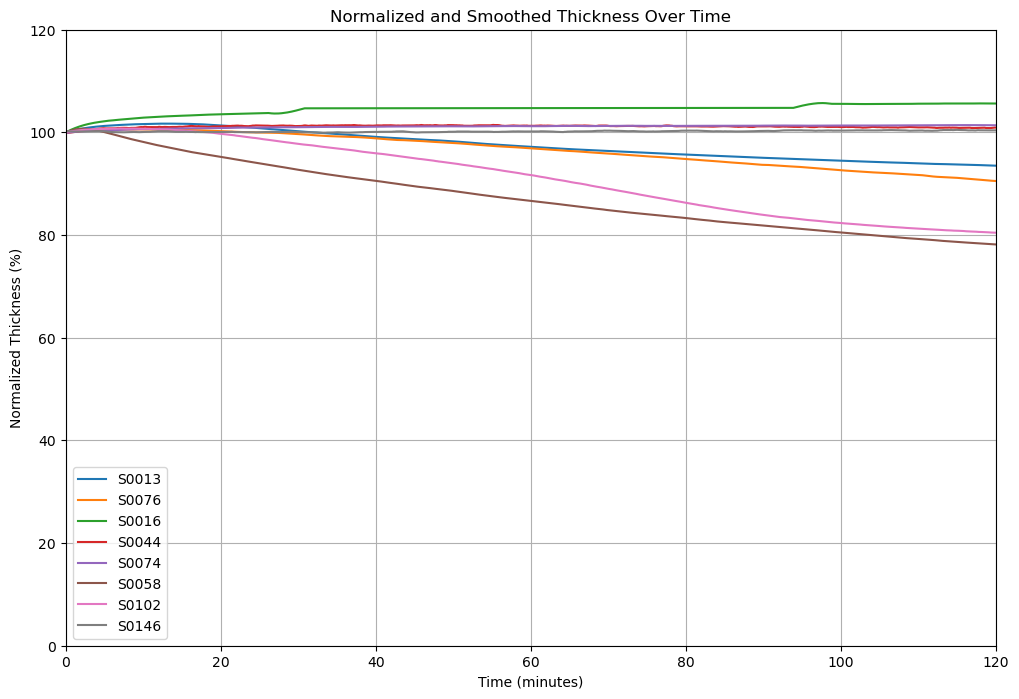

In [41]:
import pymongo
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd


# MongoDB connection
client = pymongo.MongoClient("mongodb://10.18.2.7:27017/")
db = client["MetalconeStability"]
collection = db["AirStability"]

# Retrieve all documents from the collection
docs = list(collection.find())

plt.figure(figsize=(12, 8))

for doc in docs:
    sample_id = doc['sample_id']
    time_series_measurements = doc.get('time_series_measurements', [])

    if time_series_measurements:
        # Extract time and thickness for time series
        times = [point['time'] for point in time_series_measurements]
        thicknesses = [point['thickness'] for point in time_series_measurements]

        # Normalize thicknesses to start at 100%
        initial_thickness = thicknesses[0]
        normalized_thicknesses = [(t / initial_thickness) * 100 for t in thicknesses]

        # Smooth the normalized data using Savitzky-Golay filter
        window_length = min(11, len(normalized_thicknesses) - 1) if len(normalized_thicknesses) % 2 == 0 else min(50, len(normalized_thicknesses) - 1)
        smoothed_thicknesses = savgol_filter(normalized_thicknesses, window_length=window_length, polyorder=3)

        # Plot the data
        plt.plot(times, smoothed_thicknesses, label=sample_id)
        #plt.scatter(times, normalized_thicknesses, s=10)  # Optional: scatter plot of actual data points

# Configure the plot
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized Thickness (%)')
plt.title('Normalized and Smoothed Thickness Over Time')
plt.legend()
plt.ylim(0, 120)
plt.xlim(0, 120)
plt.grid(True)

# Show the plot
plt.show()


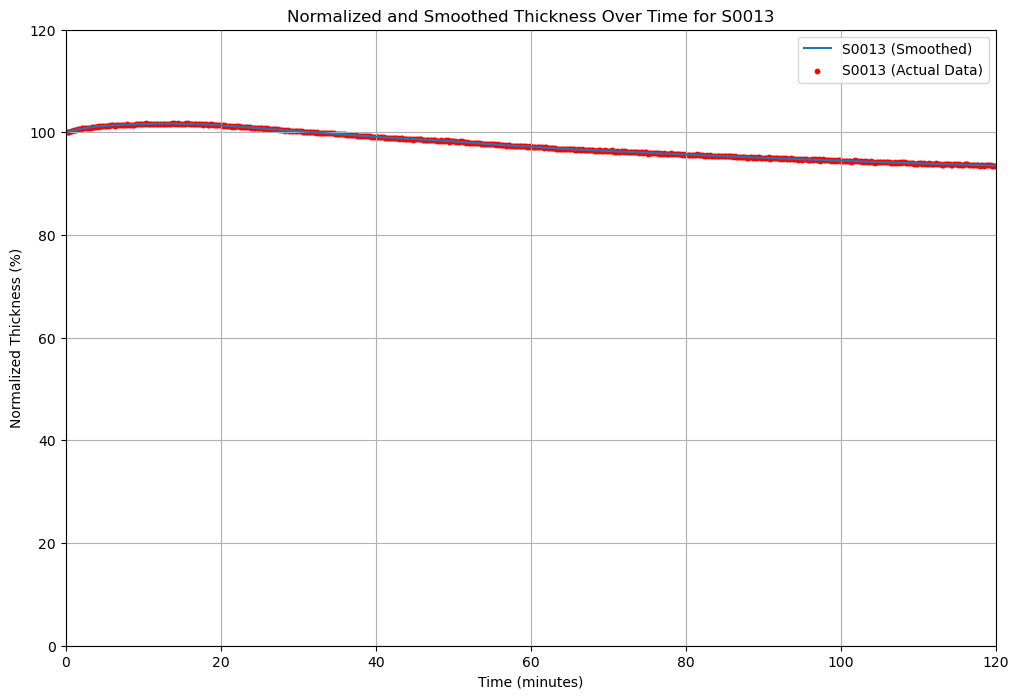

In [42]:
# Select one sample for analysis
sample_id_to_analyze = "S0013"  # Replace with the desired sample ID
doc = collection.find_one({"sample_id": sample_id_to_analyze})

if doc:
    time_series_measurements = doc.get('time_series_measurements', [])

    if time_series_measurements:
        # Extract time and thickness for time series
        times = [point['time'] for point in time_series_measurements]
        thicknesses = [point['thickness'] for point in time_series_measurements]

        # Normalize thicknesses to start at 100%
        initial_thickness = thicknesses[0]
        normalized_thicknesses = [(t / initial_thickness) * 100 for t in thicknesses]

        # Smooth the normalized data using Savitzky-Golay filter
        window_length = min(11, len(normalized_thicknesses) - 1) if len(normalized_thicknesses) % 2 == 0 else min(50, len(normalized_thicknesses) - 1)
        smoothed_thicknesses = savgol_filter(normalized_thicknesses, window_length=window_length, polyorder=3)

        # Plot the data
        plt.figure(figsize=(12, 8))
        plt.plot(times, smoothed_thicknesses, label=f'{sample_id_to_analyze} (Smoothed)')
        plt.scatter(times, normalized_thicknesses, s=10, color='red', label=f'{sample_id_to_analyze} (Actual Data)')

        # Configure the plot
        plt.xlabel('Time (minutes)')
        plt.ylabel('Normalized Thickness (%)')
        plt.title(f'Normalized and Smoothed Thickness Over Time for {sample_id_to_analyze}')
        plt.legend()
        plt.ylim(0, 120)
        plt.xlim(0, 120)
        plt.grid(True)

        # Show the plot
        plt.show()
    else:
        print(f"No time series data found for sample {sample_id_to_analyze}")
else:
    print(f"No document found for sample {sample_id_to_analyze}")


C:\Users\dreec\AppData\Local\Temp\ipykernel_17824\1416324514.py:8: RuntimeWarning: overflow encountered in exp
  lambda t: a2 * np.exp(-k2 * (t - t_change))])


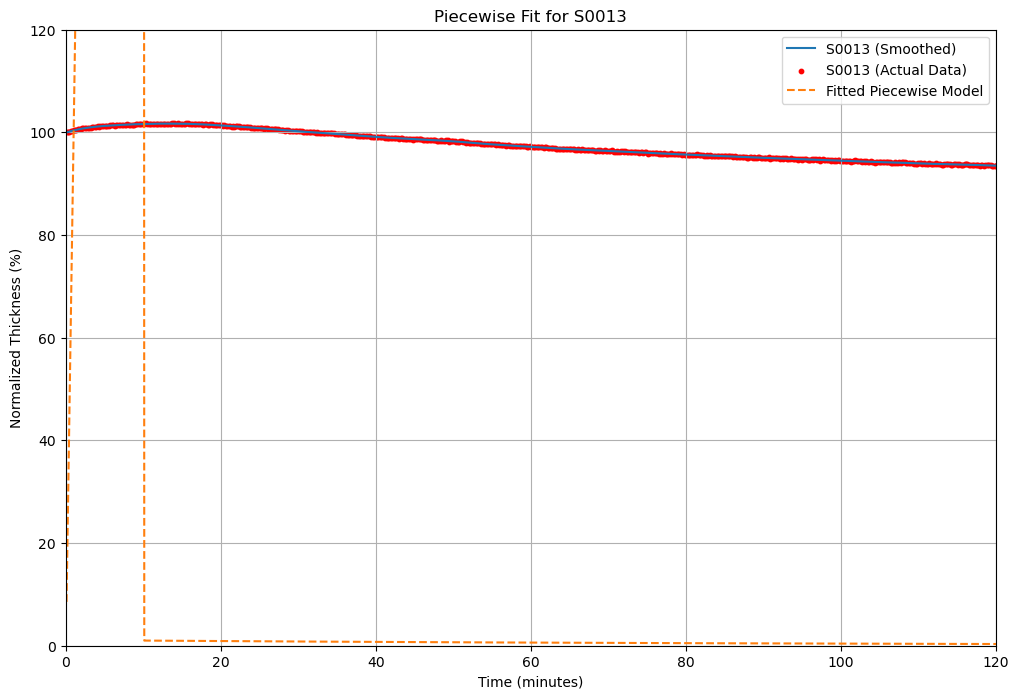

Change point (t_change): 10.111082085359062
Initial linear increase parameters (a1, b1): 0.0969725625400288, 99.99935707563016
Exponential decay parameters (a2, k2): 1.0011103567810284, 0.009976940319245436


In [45]:
from scipy.optimize import curve_fit
import numpy as np

# Define the piecewise function
def piecewise_function(t, t_change, a1, b1, a2, k2):
    return np.piecewise(t, [t < t_change, t >= t_change],
                        [lambda t: a1 + b1 * t,
                         lambda t: a2 * np.exp(-k2 * (t - t_change))])

# Fit the piecewise function to the data
if time_series_measurements:
    # Initial guess for the fitting parameters
    initial_guess = [10, 0.1, 100, 1, 0.01]

    # Fit the piecewise function
    popt, pcov = curve_fit(piecewise_function, times, smoothed_thicknesses, p0=initial_guess)

    # Extract fitting parameters
    t_change, a1, b1, a2, k2 = popt

    # Generate fitted data
    fitted_thicknesses = piecewise_function(np.array(times), *popt)

    # Plot the actual, smoothed, and fitted data
    plt.figure(figsize=(12, 8))
    plt.plot(times, smoothed_thicknesses, label=f'{sample_id_to_analyze} (Smoothed)')
    plt.scatter(times, normalized_thicknesses, s=10, color='red', label=f'{sample_id_to_analyze} (Actual Data)')
    plt.plot(times, fitted_thicknesses, label='Fitted Piecewise Model', linestyle='--')

    # Configure the plot
    plt.xlabel('Time (minutes)')
    plt.ylabel('Normalized Thickness (%)')
    plt.title(f'Piecewise Fit for {sample_id_to_analyze}')
    plt.legend()
    plt.ylim(0, 120)
    plt.xlim(0, 120)
    plt.grid(True)

    # Show the plot
    plt.show()

    # Print the fitting parameters
    print(f"Change point (t_change): {t_change}")
    print(f"Initial linear increase parameters (a1, b1): {a1}, {b1}")
    print(f"Exponential decay parameters (a2, k2): {a2}, {k2}")
else:
    print(f"No time series data found for sample {sample_id_to_analyze}")
